<a href="https://colab.research.google.com/github/SanjaraT/Diabetes_Retinopathy_Detection/blob/main/capPrac.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import kagglehub
sovitrath_diabetic_retinopathy_224x224_gaussian_filtered_path = kagglehub.dataset_download('sovitrath/diabetic-retinopathy-224x224-gaussian-filtered')

print('Data source import complete.')

100%|██████████| 427M/427M [00:03<00:00, 122MB/s]

Extracting files...


Data source import complete.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install matplotlib-venn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 1.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for matplotlib-venn: filename=matplotlib_venn-1.1.1-py3-none-any.whl size=45287 sha256=3593c56893e8fa616fc3bf36d7b534aeb06084d2fcc91e241d9eba79b1bc2d12
  Stored in directory: /root/.cache/pip/wheels/3c/b6/e2/5fadaf4aa63fac5b079d4f633e9d96b29a67ee4fae816806f3
Successfully built matplotlib-venn


In [ ]:
!pip install numpy pandas imbalanced-learn scikit-learn matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 3.8 MB/s eta 0:00:00


In [ ]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from PIL import Image

In [ ]:
df = pd.read_csv(r'/content/drive/MyDrive/train.csv')

diagnosis_dict_binary = {
    0: 'No_DR',
    1: 'DR',
    2: 'DR',
    3: 'DR',
    4: 'DR'
}

diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}


df['binary_type'] =  df['diagnosis'].map(diagnosis_dict_binary.get)
df['type'] = df['diagnosis'].map(diagnosis_dict.get)
df.head()

,id_code,diagnosis,binary_type,type
0,000c1434d8d7,2,DR,Moderate
1,001639a390f0,4,DR,Proliferate_DR
2,0024cdab0c1e,1,DR,Mild
3,002c21358ce6,0,No_DR,No_DR
4,005b95c28852,0,No_DR,No_DR


In [ ]:
df['binary_type'] = df['diagnosis'].map(diagnosis_dict_binary)
df['type'] = df['diagnosis'].map(diagnosis_dict)

In [ ]:
print(df.head())

        id_code  diagnosis binary_type            type
0  000c1434d8d7          2          DR        Moderate
1  001639a390f0          4          DR  Proliferate_DR
2  0024cdab0c1e          1          DR            Mild
3  002c21358ce6          0       No_DR           No_DR
4  005b95c28852          0       No_DR           No_DR


<Axes: ylabel='type'>

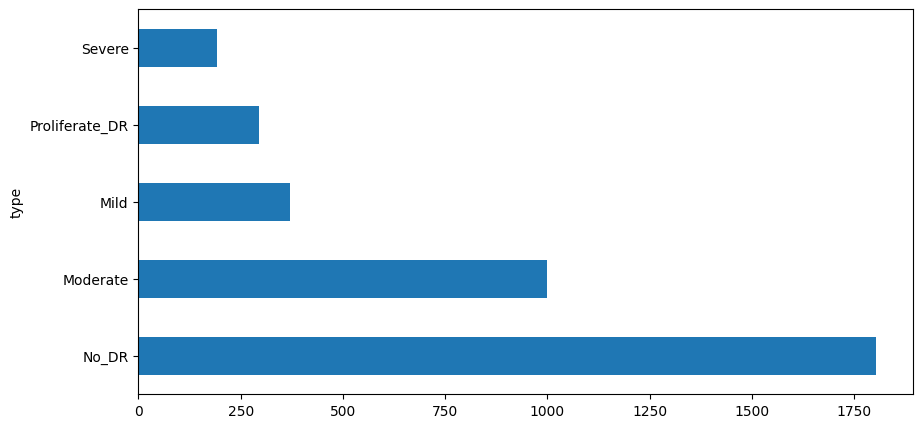

In [ ]:
plt.figure(figsize=(10, 5))
df['type'].value_counts().plot(kind='barh')

In [ ]:
# Split into stratified train, val, and test sets
train_intermediate, val = train_test_split(df, test_size = 0.15, stratify = df['type'])
train, test = train_test_split(train_intermediate, test_size = 0.15 / (1 - 0.15), stratify = train_intermediate['type'])

print(train['type'].value_counts(), '\n')
print(test['type'].value_counts(), '\n')
print(val['type'].value_counts(), '\n')

type
No_DR             1263
Moderate           699
Mild               258
Proliferate_DR     207
Severe             135
Name: count, dtype: int64 

type
No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: count, dtype: int64 

type
No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: count, dtype: int64 



In [ ]:
# Create working directories for train/val/test
base_dir = ''

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
os.makedirs(val_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)


In [ ]:
# Copy images to respective working directory
src_dir = r'/content/drive/MyDrive/gaussian_filtered_images/gaussian_filtered_images'
for index, row in train.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(train_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in val.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(val_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in test.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(test_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)


In [ ]:
train_images = []
train_labels = []

In [ ]:
for index, row in train.iterrows():
    id_code = row['id_code'] + ".png"
    img_path = os.path.join(train_dir, row['binary_type'], id_code)
    img = Image.open(img_path).resize((224, 224))
    train_images.append(np.array(img))
    train_labels.append(row['diagnosis'])

In [ ]:
X_train = np.array(train_images)
y_train = np.array(train_labels)

In [ ]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

In [ ]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train.reshape(X_train.shape[0], -1), y_train_encoded)

In [ ]:
# Reshape back to original dimensions
X_resampled = X_resampled.reshape(X_resampled.shape[0], 224, 224, 3)

In [ ]:
# Check the resampled class distribution
unique, counts = np.unique(y_resampled, return_counts=True)
resampled_distribution = dict(zip(unique, counts))

print("Resampled class distribution:")
print(resampled_distribution)

Resampled class distribution:
{0: 1263, 1: 1263, 2: 1263, 3: 1263, 4: 1263}


Text(0, 0.5, 'Type')

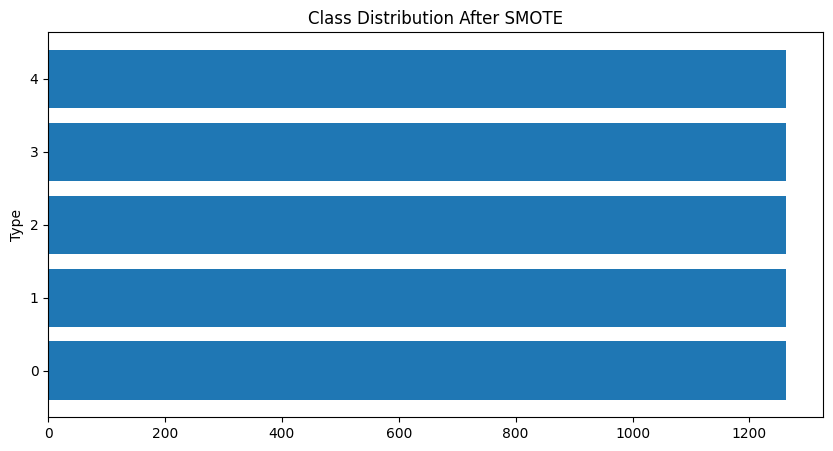

In [ ]:
plt.figure(figsize=(10, 5))
plt.barh(list(resampled_distribution.keys()), list(resampled_distribution.values()))
plt.title('Class Distribution After SMOTE')
plt.ylabel('Type')

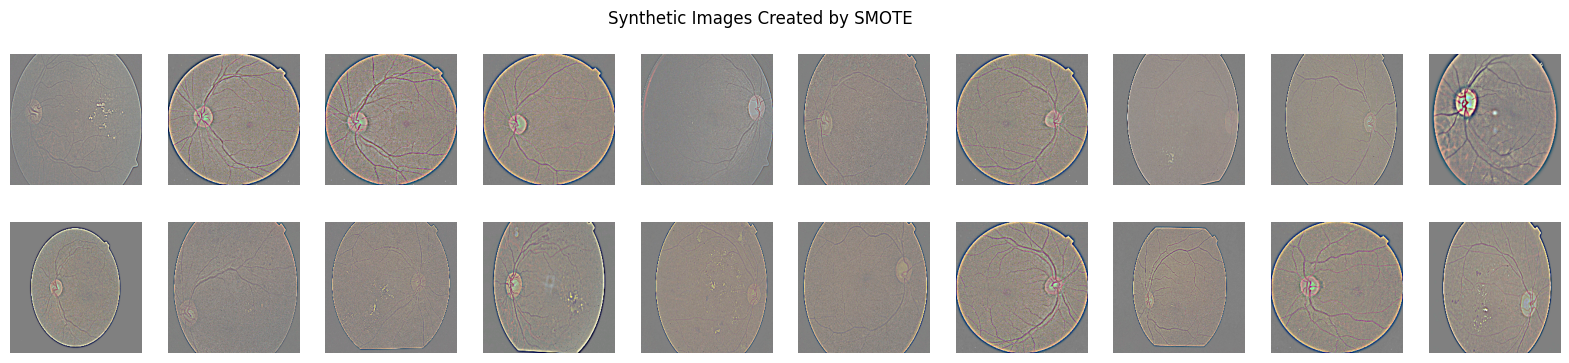

In [ ]:
# Visualize some of the synthetic images created by SMOTE
n_images_to_show = 20  # Adjust the number of images you want to display

# Reshape the resampled data back to image format
X_resampled_images = X_resampled[:n_images_to_show]  # Get the first few synthetic images

# Plotting the images
plt.figure(figsize=(20, 4))
for i in range(n_images_to_show):
    plt.subplot(2, 10, i + 1)
    plt.imshow(X_resampled_images[i].astype(np.uint8))  # Ensure the image data type is suitable for visualization
    plt.axis('off')  # Turn off axis
plt.suptitle('Synthetic Images Created by SMOTE')
plt.show()


In [ ]:
smote_dir = os.path.join(base_dir, 'smote')

In [ ]:
os.makedirs(smote_dir, exist_ok=True)

In [ ]:
# Move the SMOTE generated images to the smote directory
for i, label in enumerate(y_resampled):
    binary_label = label_encoder.inverse_transform([label])[0]  # This should be a string
    img = X_resampled[i].astype('uint8')  # Convert back to uint8
    img_path = os.path.join(smote_dir, str(binary_label))  # Ensure binary_label is a string
    os.makedirs(img_path, exist_ok=True)
    img_pil = Image.fromarray(img)
    img_pil.save(os.path.join(img_path, f'smote_image_{i}.png'))


# Now you can update the train path to include both original and SMOTE images
train_path_combined = os.path.join(base_dir, 'train_combined')
val_path = os.path.join(base_dir, 'val')
test_path = os.path.join(base_dir, 'test')
os.makedirs(train_path_combined, exist_ok=True)

# Copy original train images to the combined directory
for label in os.listdir(train_dir):
    src_label_path = os.path.join(train_dir, label)
    dst_label_path = os.path.join(train_path_combined, label)
    if not os.path.exists(dst_label_path):
        shutil.copytree(src_label_path, dst_label_path)
    else:
        # If the directory exists, copy files individually
        for img_file in os.listdir(src_label_path):
            shutil.copy(os.path.join(src_label_path, img_file), dst_label_path)

# Copy SMOTE images to the combined directory
for label in os.listdir(smote_dir):
    src_label_path = os.path.join(smote_dir, label)
    dst_label_path = os.path.join(train_path_combined, label)
    if not os.path.exists(dst_label_path):
        shutil.copytree(src_label_path, dst_label_path)
    else:
        # If the directory exists, copy files individually
        for img_file in os.listdir(src_label_path):
            shutil.copy(os.path.join(src_label_path, img_file), dst_label_path)

# Update the image data generators
train_batches = ImageDataGenerator(rescale=1./255).flow_from_directory(
    train_path_combined,
    target_size=(224, 224),
    shuffle=True
)

val_batches = ImageDataGenerator(rescale=1./255).flow_from_directory(
    val_path,
    target_size=(224, 224),
    shuffle=True
)

test_batches = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_path,
    target_size=(224, 224),
    shuffle=False
)

Found 8877 images belonging to 7 classes.
Found 550 images belonging to 2 classes.
Found 550 images belonging to 2 classes.


In [ ]:
combined_df = pd.DataFrame()

In [ ]:
# Getting the paths of images and their corresponding labels
image_paths = []
labels = []

In [ ]:
# Loop through 'train_combined' directory to gather the image paths and their corresponding labels
for label in os.listdir(train_path_combined):
    label_folder_path = os.path.join(train_path_combined, label)
    for img_file in os.listdir(label_folder_path):
        image_paths.append(os.path.join(label_folder_path, img_file))
        labels.append(label)

In [ ]:
# Adding image paths and labels to the DataFrame
combined_df['image_path'] = image_paths
combined_df['binary_type'] = labels

In [ ]:
# Check the first few records
print(combined_df)

                                 image_path binary_type
0     train_combined/2/smote_image_1198.png           2
1       train_combined/2/smote_image_95.png           2
2     train_combined/2/smote_image_3642.png           2
3     train_combined/2/smote_image_3734.png           2
4     train_combined/2/smote_image_3720.png           2
...                                     ...         ...
8872  train_combined/1/smote_image_3448.png           1
8873  train_combined/1/smote_image_2752.png           1
8874  train_combined/1/smote_image_3024.png           1
8875  train_combined/1/smote_image_3330.png           1
8876  train_combined/1/smote_image_3335.png           1

[8877 rows x 2 columns]


In [ ]:
# Encoding the labels to numerical values for analysis
label_encoder = LabelEncoder()
combined_df['encoded_binary_type'] = label_encoder.fit_transform(combined_df['binary_type'])

#EDA

In [ ]:
def image_statistics(images, dataset_label="Dataset"):
    means = []
    stds = []

    # Calculate mean and std for each image
    for img in images:
        means.append(np.mean(img))
        stds.append(np.std(img))

    # Print the statistics for the dataset
    print(f"{dataset_label} - Mean pixel value: {np.mean(means):.4f}")
    print(f"{dataset_label} - Standard deviation of pixel values: {np.mean(stds):.4f}")
    print(f"{dataset_label} - Number of images: {len(images)}\n")

# Check statistics for original dataset (X_train) and resampled dataset (X_resampled)
image_statistics(X_train, dataset_label="Original Dataset")
image_statistics(X_resampled, dataset_label="Resampled (SMOTE) Dataset")

Original Dataset - Mean pixel value: 135.3238
Original Dataset - Standard deviation of pixel values: 20.0314
Original Dataset - Number of images: 2562

Resampled (SMOTE) Dataset - Mean pixel value: 131.8517
Resampled (SMOTE) Dataset - Standard deviation of pixel values: 31.2704
Resampled (SMOTE) Dataset - Number of images: 6315



In [ ]:
# Check for missing files
def check_missing_files(image_paths):
    missing_files = []
    for path in image_paths:
        if not os.path.exists(path):
            missing_files.append(path)

    print(f"Total missing files: {len(missing_files)}")
    if missing_files:
        print(f"Example of missing files: {missing_files[:5]}")  # Display first 5 missing files

check_missing_files(image_paths)

Total missing files: 0


In [ ]:
import seaborn as sns

In [ ]:
# Parameters
subset_size = 5  # Adjust based on available memory

# Randomly select a subset of images
if subset_size > X_resampled.shape[0]:
    raise ValueError("Subset size exceeds the number of available images.")

# Select random indices for the subset
subset_indices = np.random.choice(X_resampled.shape[0], subset_size, replace=False)

# Extract the subset using the indices
subset_images = X_resampled[subset_indices]

# Flatten the images to 1D and calculate correlation on the subset
subset_images_flat = subset_images.reshape(subset_images.shape[0], -1)

# Compute correlation matrix for the subset
corr_matrix_subset = np.corrcoef(subset_images_flat.T)  # Transpose for pixel-wise correlation

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix_subset, cmap='coolwarm', cbar=True)
plt.title('Pixel Correlation Matrix (Subset)')
plt.show()
